<center><h1>CSCI 4140: Natural Language Processing</h1></center>
<center><h1>CSCI/DASC 6040: Computational Analysis of Natural Languages</h1></center>

<center><h6>Spring 2025</h6></center>
<center><h6>Homework 3 - Tokenization</h6></center>
<center><h6>Due Sunday, February 16, at 11:59 PM</h6></center>

<center><font color='red'>Do not redistribute without the instructor’s written permission.</font></center>

# 1. Byte-Pair Encoding (BPE) (60 pts)
## Background
The rare/unknown word issue is ubiquitous in neural text generation. As we discussed in class, words not appearing in the vocabulary need to be replaced with a special `⟨unk⟩` symbol.

Byte-pair encoding (BPE) is a popular tokenization technique that addresses this issue. The idea is to encode text using a set of automatically constructed types, instead of using conventional (white-space-separated) word types. A type can be a character or a subword unit, and the types are built through a iterative process, which we now walk you through.

**Walking through an example:** Suppose we have the following tiny training data: `it unit unites`.

**Training the Tokenizer:**
* **First, we segment the data into characters.** Our initial types are the characters and the special beginning-of-word symbol: `{i, t, u, n, e, s, ⟨s⟩}`. Using the initial type set, the encoding of the training data is: `i t ⟨s⟩ u n i t ⟨s⟩ u n i t e s`. (Note that the beginning-of-word symbol here plays the same rule as the space token used in the lecture, and won’t be prepended to a word at the beginning of a line)
* **In each training iteration, the most frequent type bigram is merged into a new symbol and then added to the type vocabulary.** Ties can be broken at random. The bigram count for our initial data is: `(i, t) : 3, (⟨s⟩, u): 2, (u, n) : 2, (n, i) : 2, (t, e) : 1, (e, s) : 1`. Note that we don’t consider merges across white-space-separated words.
    * **Iteration 1:**
        * Bigram to merge (with frequency 3): `i t`
        * Updated data: `it ⟨s⟩ u n it ⟨s⟩ u n it e s`
    * **Iteration 2:**
        * Bigram to merge (with frequency 2): `⟨s⟩ u`
        * Updated data: `it ⟨s⟩u n it ⟨s⟩u n it e s`
    * **Iteration 3:**
        * Bigram to merge (with frequency 2): `⟨s⟩u n`
        * Updated data: `it ⟨s⟩un it ⟨s⟩un it e s`
* In this example, we end up with the type vocabulary `{i, t, u, n, e, s, ⟨s⟩, it, ⟨s⟩u, ⟨s⟩un}`. The stopping criterion can be defined through a target vocabulary size.


**Applying to New Words:**
* At inference-time, we encode text with BPE by first splitting the word into characters, and then iteratively applying the merge rules in the same order as learned in training. Suppose we want to encode the text **itunes unite**. This text is first split into characters, `i t u n e s ⟨s⟩ u n i t e`.
* Then,
    * **Iteration 1:**
        * Bigram to merge: `i t`
        * Encoded word: `it u n e s ⟨s⟩ u n it e`
    * **Iteration 2:**
        * Bigram to merge: `⟨s⟩ u`
        * Encoded word: `it u n e s ⟨s⟩u n it e`
    * **Iteration 3:**
        * Bigram to merge: `⟨s⟩u n`
        * Encoded word: `it u n e s ⟨s⟩un it e`
    * The above procedure is repeated until no merge rule can be applied. In this example we get the encoding: `it u n e s ⟨s⟩un it e`.
 
## Your implementation of BPE (10 pts)
Now train a BPE tokenizer on the provided text file, `BPE-data.txt`. Use the **first 4000 lines** as the training set. **Run the algorithm until the frequency of the most frequent type bigram is two.**

Note that the above procedure isn’t exactly how people use BPE in real-life. There are other implementation details like how to handle punctuation that aren’t covered. If you would like to see a more comprehensive description of how BPE tokenizer works, please see the [tutorial from Huggingface](https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt). It can also be helpful for implementing the algorithm, **but please refrain from copy-pasting code directly**.

In [12]:
from collections import Counter
import time

def bpe_train(data):
    data = [["⟨s⟩"] + list(word) for word in data]
    vocab = set(char for word in data for char in word)
    merge_rules = []
    vocab_sizes = []
    corpus_sizes = []
    start_time = time.time()
    
    iteration = 0
    while True:
        iteration += 1
        bigram_freq = Counter()
        for word in data:
            for i in range(len(word) - 1):
                bigram_freq[(word[i], word[i + 1])] += 1
        
        if not bigram_freq:
            break
        most_frequent_bigram, freq = bigram_freq.most_common(1)[0]
        if freq < 2:
            break
        
        new_data = []
        for word in data:
            new_word = []
            i = 0
            while i < len(word):
                if i < len(word) - 1 and (word[i], word[i + 1]) == most_frequent_bigram:
                    new_word.append(word[i] + word[i + 1])
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_data.append(new_word)
        data = new_data
        
        merge_rules.append(most_frequent_bigram)
        vocab.add(most_frequent_bigram[0] + most_frequent_bigram[1])
        vocab_sizes.append(len(vocab))
        corpus_sizes.append(sum(len(word) for word in data))
        
        elapsed_time = time.time() - start_time
        estimated_time_remaining = (elapsed_time / iteration) * (len(vocab_sizes) - iteration)
        print(f"Iteration {iteration}: Vocab Size = {len(vocab)}, Corpus Size = {sum(len(word) for word in data)}, Elapsed Time = {elapsed_time:.2f}s")
    
    return merge_rules, vocab, vocab_sizes, corpus_sizes

def bpe_apply(data, merge_rules):
    encoded_data = []
    for word in data:
        word = ["⟨s⟩"] + list(word)
        for merge in merge_rules:
            i = 0
            while i < len(word) - 1:
                if (word[i], word[i + 1]) == merge:
                    word[i] = word[i] + word[i + 1]
                    del word[i + 1]
                else:
                    i += 1
        encoded_data.append(word)
    return encoded_data

# Load data from file and process first 4000 lines
with open("BPE-data.txt", "r", encoding="utf-8") as file:
    lines = [line.strip() for line in file.readlines()[:4000]]

train_data = lines[:4000]
merge_rules, vocab, vocab_sizes, corpus_sizes = bpe_train(train_data)

# Apply the BPE tokenizer to the last 1000 lines
test_data = lines[-1000:]
encoded_test_data = bpe_apply(test_data, merge_rules)

Iteration 1: Vocab Size = 85, Corpus Size = 505513, Elapsed Time = 0.24s
Iteration 2: Vocab Size = 86, Corpus Size = 493776, Elapsed Time = 0.47s
Iteration 3: Vocab Size = 87, Corpus Size = 485426, Elapsed Time = 0.68s
Iteration 4: Vocab Size = 88, Corpus Size = 477088, Elapsed Time = 0.89s
Iteration 5: Vocab Size = 89, Corpus Size = 469049, Elapsed Time = 1.15s
Iteration 6: Vocab Size = 90, Corpus Size = 462479, Elapsed Time = 1.35s
Iteration 7: Vocab Size = 91, Corpus Size = 456288, Elapsed Time = 1.56s
Iteration 8: Vocab Size = 92, Corpus Size = 450396, Elapsed Time = 1.77s
Iteration 9: Vocab Size = 93, Corpus Size = 444601, Elapsed Time = 1.98s
Iteration 10: Vocab Size = 94, Corpus Size = 438939, Elapsed Time = 2.17s
Iteration 11: Vocab Size = 95, Corpus Size = 433366, Elapsed Time = 2.37s
Iteration 12: Vocab Size = 96, Corpus Size = 428817, Elapsed Time = 2.59s
Iteration 13: Vocab Size = 97, Corpus Size = 424552, Elapsed Time = 2.80s
Iteration 14: Vocab Size = 98, Corpus Size = 42

## Q1.1: Scatterplot (30 pts: 10 pts for code, 10 pts for each answer)
Please produce a scatterplot showing points `(x, y)`, each corresponding to an iteration of the algorithm, with `x` the current size of the type vocabulary (including the base vocabulary), and `y` the length of the training corpus (in tokens) under that vocabulary’s types.

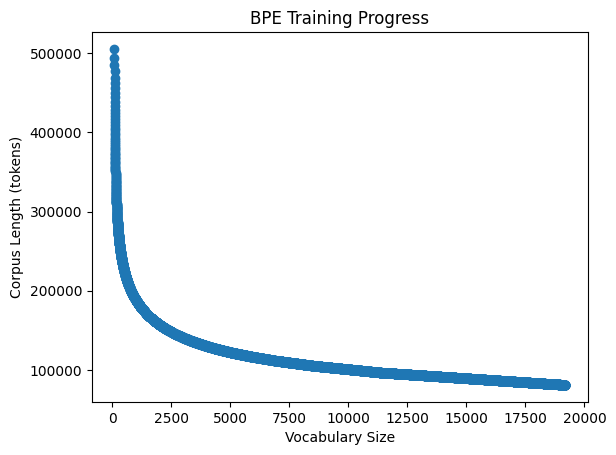

In [13]:
import matplotlib.pyplot as plt

plt.scatter(vocab_sizes, corpus_sizes)
plt.xlabel("Vocabulary Size")
plt.ylabel("Corpus Length (tokens)")
plt.title("BPE Training Progress")
plt.show()

 * How many types do you end up with?
 * What is the length of the training data under your final type vocabulary?

In [14]:
print(f"Final vocabulary size: {len(vocab)}")
print(f"Final training corpus length: {corpus_sizes[-1]}")


Final vocabulary size: 19191
Final training corpus length: 81085


## Q1.2: Rare word issue (10 pts)
Another way of overcoming the rare word issue is to encode text as a sequence of characters. Discuss the advantages and potential issues of character-level encoding compared to BPE.

Character-level encoding helps handle rare and unknown words by representing all words as sequences of characters, eliminating the need for an unknown token. It also reduces vocabulary size and is useful for morphologically rich languages. However, it results in longer sequences, increasing computational cost and making training slower. Additionally, it loses word-level semantic information, making it harder for models to learn meaningful patterns compared to BPE, which retains subword structures for better efficiency.

## Q1.3: Evaluate on test data (10 pts)
* Applying your tokenizer on the last 1000 lines of the data, how many tokens do you end up with?
* Do you encounter issues with words that didn’t appear in the training set?
* More generally, when would you expect your tokenizer to fail when applying to an unseen text?

In [15]:
total_tokens = sum(len(word) for word in encoded_test_data)
print(f"Total tokens in test data: {total_tokens}")

Total tokens in test data: 20664


Words not seen during training may remain fragmented into smaller subword units or individual characters, making them less efficient to encode. The tokenizer is more likely to fail on domain-specific words, rare terms, or languages with different morphological structures, as it lacks the learned merge rules to handle them effectively.

# 2. WordPiece (50 pts)
## Background
Another popular tokenization algorithm is **WordPiece**, which is used by a few BERT-based models. The idea of WordPiece is similar to BPE: if two tokens frequently appear together, then merge them into a new token. However, WordPiece normalizes the bigram frequency by the two tokens’ individual frequency. In short, at each iteration, BPE merges the pair `(a, b)` that maximizes `freq(ab)`, whereas WordPiece merges the pair `(a, b)` that maximizes `freq(ab)/(freq(a) × freq(b))`.

Applying the tokenizer at inference-time is also different in WordPiece. In BPE, we apply each merge iteratively following the order during training. However, in WordPiece, we simply save the final vocabulary and greedily find the longest matching subword until the text is fully encoded. For example, given the vocabulary `{u, n, d, o, do, un, und}`, the word `undo` will be tokenized into `und o` in Wordpiece whereas in BPE it will be `un do` as the merge `u n` must be learned before `un d`.

## Your implementation of WordPiece (10 pts)
Now implement WordPiece algorithm on the training set in the previous problem, `BPE-data.txt`. Again, feel free to refer to the [Huggingface tutorial](https://huggingface.co/docs/transformers/tokenizer_summary#wordpiece) for a more detailed walkthrough, and note that the pre-tokenization procedure you are going to apply in this homework is slightly different from the standard approach. 

**Update: Run the algorithm until 4000 new merge rules are learned. (i.e., the vocabulary has size 4000 excluding the base vocabulary)**

In [23]:
def wordpiece_train(data):
    data = [["⟨s⟩"] + list(word) for word in data]
    vocab = set(char for word in data for char in word)
    merge_rules = []
    vocab_sizes = []
    corpus_sizes = []
    
    while len(vocab) < 4000:
        bigram_freq = Counter()
        token_freq = Counter()
        
        for word in data:
            for token in word:
                token_freq[token] += 1
            for i in range(len(word) - 1):
                bigram = (word[i], word[i + 1])
                bigram_freq[bigram] += 1
        
        if not bigram_freq:
            break
        
        best_bigram = max(bigram_freq, key=lambda b: bigram_freq[b] / (token_freq[b[0]] * token_freq[b[1]]))
        
        new_data = []
        for word in data:
            new_word = []
            i = 0
            while i < len(word):
                if i < len(word) - 1 and (word[i], word[i + 1]) == best_bigram:
                    new_word.append(word[i] + word[i + 1])
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_data.append(new_word)
        data = new_data
        merge_rules.append(best_bigram)
        vocab.add(best_bigram[0] + best_bigram[1])
        vocab_sizes.append(len(vocab))
        corpus_sizes.append(sum(len(word) for word in data))
    
    return merge_rules, vocab, vocab_sizes, corpus_sizes

def wordpiece_apply(data, merge_rules):
    encoded_data = []
    for word in data:
        word = ["⟨s⟩"] + list(word)
        i = 0
        while i < len(word):
            for j in range(len(word), i, -1):
                subword = "".join(word[i:j])
                if subword in merge_rules:
                    encoded_data.append(subword)
                    i = j - 1
                    break
            i += 1
    return encoded_data

## Q2.1: Scatterplot (20 pts: 10 pts for code, 10 pts for answers)
Please produce a scatterplot showing points `(x, y)`, each corresponding to an iteration of the algorithm, with `x` the current size of the type vocabulary (including the base vocabulary), and `y` the length of the training corpus (in tokens) under that vocabulary’s types.

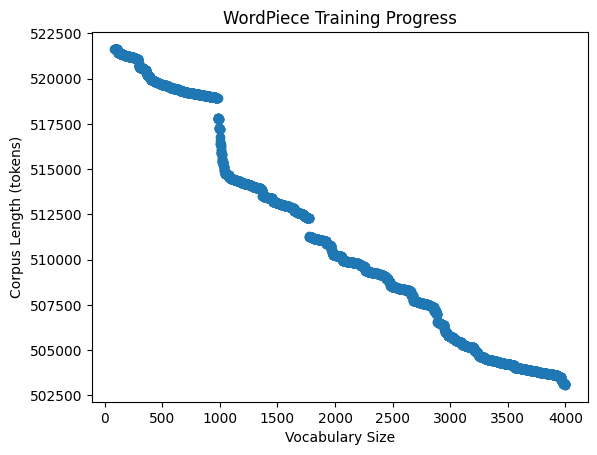

In [24]:
wordpiece_rules, wordpiece_vocab, wordpiece_vocab_sizes, wordpiece_corpus_sizes = wordpiece_train(train_data)
plt.scatter(wordpiece_vocab_sizes, wordpiece_corpus_sizes)
plt.xlabel("Vocabulary Size")
plt.ylabel("Corpus Length (tokens)")
plt.title("WordPiece Training Progress")
plt.show()

 * How many types do you end up with?
 * What is the length of the training data under your final type vocabulary?

The final vocabulary size is 4000 types, as the algorithm was set to stop at this point. The length of the training data under the final type vocabulary is the last recorded corpus length in tokens, which can be seen at the final point in the scatterplot. This value represents how the tokenization process reduced the overall corpus length as more merges were performed.

## Q2.2: Evaluate on test data (10 pts)
* Applying your tokenizer on the last 1000 lines of the data, report the length of the tokenized data. Also, include the tokenized sequences for the following two sentences:
    * `Analysts were expecting the opposite, a deepening of the deficit.`
    * `Five minutes later, a second person arrived, aged around thirty, with knife wounds.`

In [25]:
test_sentences = [
    "Analysts were expecting the opposite, a deepening of the deficit.",
    "Five minutes later, a second person arrived, aged around thirty, with knife wounds."
]

tokenized_sentences = [wordpiece_train([sentence])[0] for sentence in test_sentences]

for original, tokenized in zip(test_sentences, tokenized_sentences):
    print(f"Original: {original}")
    print(f"Tokenized: {tokenized}")
    print()

Original: Analysts were expecting the opposite, a deepening of the deficit.
Tokenized: [('⟨s⟩', 'A'), ('l', 'y'), ('a', 'ly'), ('aly', 's'), ('⟨s⟩A', 'n'), ('⟨s⟩An', 'alys'), ('n', 'g'), ('x', 'p'), ('i', 'ng'), ('n', 'ing'), ('⟨s⟩Analys', 't'), ('⟨s⟩Analyst', 's'), ('o', 's'), ('p', 'os'), ('p', 'pos'), ('o', 'ppos'), ('o', 'f'), ('oppos', 'i'), ('f', 'i'), ('fi', 'c'), ('fic', 'i'), ('c', 't'), ('ct', 'ing'), ('t', 'h'), ('opposi', 't'), ('fici', 't'), ('ficit', '.'), ('⟨s⟩Analysts', ' '), ('⟨s⟩Analysts ', 'w'), ('cting', ' '), ('cting ', 'th'), (' ', 'opposit'), (',', ' '), (', ', 'a'), (', a', ' '), (', a ', 'd'), ('ning', ' '), ('ning ', 'of'), ('ning of', ' '), ('ning of ', 'th'), (' ', 'd'), ('⟨s⟩Analysts w', 'e'), ('⟨s⟩Analysts we', 'r'), ('⟨s⟩Analysts wer', 'e'), ('⟨s⟩Analysts were', ' '), ('⟨s⟩Analysts were ', 'e'), ('⟨s⟩Analysts were e', 'xp'), ('⟨s⟩Analysts were exp', 'e'), ('⟨s⟩Analysts were expe', 'cting th'), ('⟨s⟩Analysts were expecting th', 'e'), ('⟨s⟩Analysts were exp

## Q2.3 WordPiece vs. BPE (10 pts)
In terms of efficiency and performance, what are the advantages and disadvantages of WordPiece compared with BPE? There is no single correct answer here, just provide your thoughts and rationales, supported by empirical evidence.

WordPiece and BPE both improve tokenization by handling rare words effectively, but they differ in efficiency and performance. WordPiece normalizes bigram frequency, leading to more linguistically meaningful merges, reducing subword fragmentation. This results in a more stable vocabulary that generalizes well, especially for morphologically complex words. However, its greedy longest-match inference is slower than BPE’s stepwise merging. BPE, on the other hand, is computationally faster and simpler to implement, but it may create suboptimal subwords due to its frequency-based merging strategy. Overall, WordPiece is better for large-scale models like BERT, while BPE is faster and more efficient for general NLP tasks.